# Part 4 ... initial analyses

Lets start to test the original thesis that gas stations are not visited continuously and that there is therefore sufficient time between peak hours to recharge buffer storages, I will approach it step by step.

First I will conduct initial investigations regarding the frequency of use of selected gas stations. I will focus on gas stations (type: "gas station") with characteristics of motorways (name or address contains corresponding key terms). What statements can be made?

Second, I look at how the numbers behave over the course of the entire week. 

And thirdly, what about other location categories, as well as the total number of locations surveyed?

Finally, have a look at which of the statements given are useful for evaluating the thesis and which are not so much. The graphs shown on the way give a pretty good impression of which approaches are worthwhile.

**Loading necessary libraries**

In [1]:
import psycopg2
from credentials import Credentials
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 

In [2]:
class GasStationDB(Credentials):
    def __init__(self):
        super().__init__()
        self.conn = psycopg2.connect(dbname=self.DBNAME, user=self.DBUSER, password=self.DBPASS)
        self.cur = self.conn.cursor() 

#### Connect the db

In [3]:
GDB = GasStationDB()

## Data of a single arbitrary day

To begin with, I select an arbitrary data set for a day in order to prepare and test the various data. 

### Gas stations with Autobahn and BAB in name or address as well as recorded peak times

The database query shall give me the peak hours for all locations that were recorded on a Monday. The locations should also be somehow related to motorways. I choose the approach that the term Autobahn or BAB (short for federal motorway) can be found in the address or in the name.

The table below shows some rows of the query results. In total, the query returns 116 records.

In [4]:
GDB = GasStationDB()
query = """SELECT * FROM portfolio.guest_quantities 
                 WHERE weekday = 1 AND hr00 IS NOT NULL AND station_id IN 
                       (SELECT station_id FROM portfolio.stations 
                          WHERE LOWER(name) LIKE '%autobahn%' 
                          OR LOWER(name) LIKE '%bab%'
                          OR LOWER(address) LIKE '%autobahn%'
                          OR LOWER(address) LIKE '%bab%'
                 AND station_id IN 
                       (SELECT ts_stations_id FROM portfolio.type_place 
                          WHERE ts_types_id = 1))
                 ORDER BY station_id;
                 """
GDB.cur.execute(query)
table = GDB.cur.fetchall()
weekday_autobahn = pd.DataFrame(table, columns=[col[0] for col in GDB.cur.description])
GDB.conn.close()
print(weekday_autobahn.shape[0]+1)
weekday_autobahn[::50]

116


,quant_id,station_id,weekday,hr00,hr01,hr02,hr03,hr04,hr05,hr06,...,hr14,hr15,hr16,hr17,hr18,hr19,hr20,hr21,hr22,hr23
0,1266,185,1,10,4,1,1,1,1,4,...,53,44,35,29,25,24,23,22,20,15
50,4450,642,1,0,0,0,0,7,21,39,...,76,77,69,53,34,18,7,2,0,0
100,22936,3325,1,70,68,65,62,58,53,48,...,61,60,60,61,65,69,73,75,75,73


### Peak times diagramm of the three previously selected gas stations 

The arbitrary selection shows different time profiles of the peak times of the table shown before. As you can see here quite well, the occupancy rate is not always above 50%. The x-axis represents the course of the daytime hours. The y-axis shows the percentage occupancy rate. 

array([<AxesSubplot:title={'center':'100'}>], dtype=object)

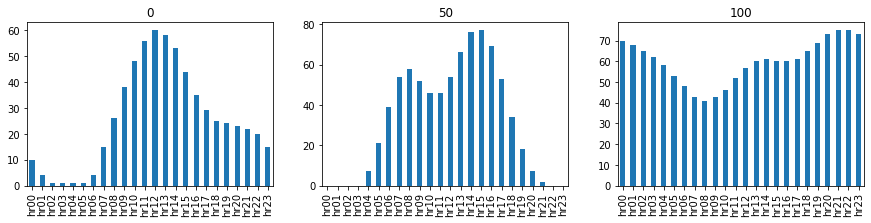

In [5]:
wa_sample = weekday_autobahn.iloc[::50]
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,3))
wa_sample.iloc[0,3:].plot.bar(subplots=True, ax = axes[0])
wa_sample.iloc[1,3:].plot.bar(subplots=True, ax = axes[1])
wa_sample.iloc[2,3:].plot.bar(subplots=True, ax = axes[2])

### Peak times of all selected stations

Below is the comparison of the peak hours of five of all stations on the arbitrarily selected day, with the mentioned characteristics motorway, BAB. 

For an initial overview, I create a heat map with the relative workloads over 24 hours. Fields marked in blue correspond to hours with no or low percentage occupancy. Fields marked in red correspond to hours with high percentage occupancy. These are different locations than previously shown. These are also choosen arbitrarily.

<AxesSubplot:>

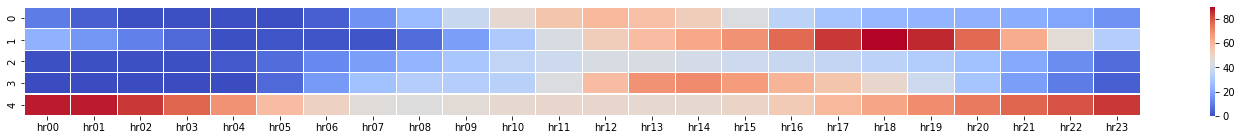

In [6]:
fig, ax = plt.subplots(figsize = (25, 2))
wa_freq = weekday_autobahn.iloc[:,3:].copy()
sns.heatmap(wa_freq[:5], cmap ='coolwarm', linewidths = 0.30, annot = False)

### Relative customer amount lower 30 % for each station

I will keep the total number of stations (I will continue to use the query result from above) and see how many hours have a relative occupancy of less than 30%. The value 30% is also chosen arbitrarily at first, but seems to be a good value for making rough estimates. During these times, the battery storage should also be able to be recharged a little. 

The table shows the number of hours with an relative occupancy lower 30 % (row lower_30: in hours / row pct: in percentage of the day).

In [7]:
wa_lower30 = weekday_autobahn.iloc[:,3:].copy()
mask = wa_lower30 < 30
wa_lower30['lower30'] = wa_lower30[mask].count(axis=1)
wa_lower30['pct'] = wa_lower30['lower30'] * 100 / 24 
wa_lower30[['lower30', 'pct']].round(2).T

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
lower30,16.00,10.00,13.00,12.0,0.0,19.00,11.00,8.00,4.00,16.00,...,17.00,0.0,10.00,13.00,12.0,13.00,0.0,12.0,16.00,13.00
pct,66.67,41.67,54.17,50.0,0.0,79.17,45.83,33.33,16.67,66.67,...,70.83,0.0,41.67,54.17,50.0,54.17,0.0,50.0,66.67,54.17


**Number of stations in which more than 12 hours have a occupancy rate below 30%.**

Here I make a further restriction and have the number of stations displayed for which the occupancy rate is less than 30% on more than 50% of the day. Perhaps some of these 43 locations are interesting for the installation of battery storages. Roughly speaking, there should be a few locations that allow a positive state of charge of the battery on average.

In [8]:
mask = wa_lower30['lower30'] > 12
low30_hr12 = wa_lower30['lower30'][mask]
low30_hr12.count()

43

### Frequency of locations by hours with a occupancy rate of less than 30%

We take a look at the frequency of the sites with the previously mentioned constraints. How much do the locations differ in terms of 30% occupancy. The left diagram shows the frequency of the 43 stations mentioned above, corresponding to the number of hours with a load factor of less than 30%. The chart on the right shows the frequencies of stations with less than 30% occupancy for 12 hours or more. Shown is the number of stations with corresponding hours below 30%. 

Among the remaining locations, there are even those where the occupancy rate (on the arbitrarily chosen day) is below 30% for more than 20 hours.

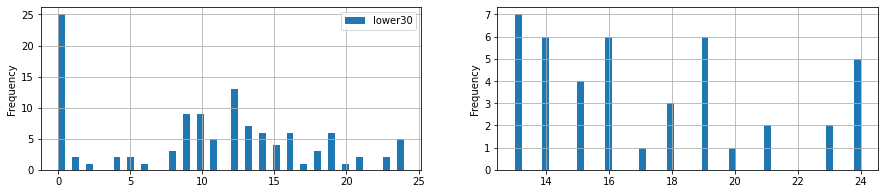

In [9]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,3))
ax = wa_lower30[['lower30']].plot.hist(bins=50, grid=True, subplots=True, ax=axes[0])
ax = low30_hr12.plot.hist(bins=50, grid=True, subplots=True, ax=axes[1])

### Average daily load

Next, I ask myself how high the average occupancy of the locations is spread out over the day. Possibly this statement could also be helpful to check the application of battery storage.

The left diagram shows the Percentage average daily occupancy of the locations, the right diagram shows the frequency of average daily occupancy. The right diagram shows a very nice distribution of occupancies across the locations. Most often, the average daily occupnacy is around 30%. Full occupancies of for example over 60% are seen less often.

44 stations have a daily load of less than 30% (on the arbitrarily chosen weekday)

The average daily occupancy rate is calculated as follows: 

Daily load = sum of the hourly individual loads / 24 hours

In [10]:
wa_load = weekday_autobahn.iloc[:,3:].copy()
wa_load['dayload'] = wa_load.sum(axis=1)
wa_load['pct_dayload'] = wa_load['dayload']/24
wa_load[['dayload', 'pct_dayload']].T.round(1)

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
dayload,613.0,966.0,555.0,728.0,1515.0,403.0,823.0,878.0,1182.0,521.0,...,445.0,1364.0,937.0,668.0,757.0,651.0,1193.0,892.0,696.0,574.0
pct_dayload,25.5,40.2,23.1,30.3,63.1,16.8,34.3,36.6,49.2,21.7,...,18.5,56.8,39.0,27.8,31.5,27.1,49.7,37.2,29.0,23.9


In [11]:
mask = wa_load['pct_dayload'] < 30
load = wa_load['pct_dayload'][mask]
load.count()

44

Text(0.5, 0, 'percentage average daily occupancy')

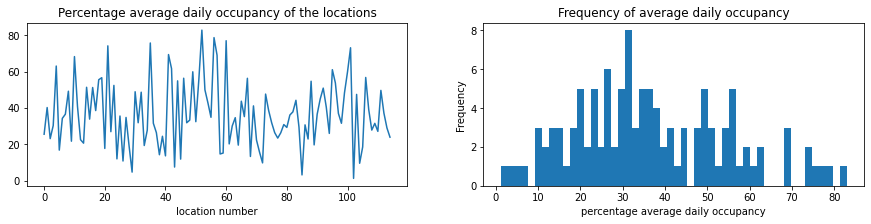

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
ax1 = wa_load['pct_dayload'].plot(ax = axes[0])
ax2 = wa_load['pct_dayload'].plot.hist(ax=axes[1], bins=50)
ax1.set_title('Percentage average daily occupancy of the locations')
ax1.set_xlabel('location number')
ax2.set_title('Frequency of average daily occupancy')
ax2.set_xlabel('percentage average daily occupancy')

### Example calculation

With the results of the previous considerations, some example calculations should actually show that battery storage can fulfill its task there. They should not be discharged to 0% in between so that they can provide energy for the charging stations.

At this point I would like to make an example calculation with very strong simplifications. Please note that these are not real usable calculations. Many factors that should actually be taken into account are completely excluded here. It is a very rough calculative estimate.

The idea is to carry out an hourly step-by-step calculation for the capacity of a fictitious storage system. I would like to calculate with the following assumptions:

- Charging station: 4 x 200 kW charging capacity (charge_max = 800 kW).
- Load corresponds to the existing hourly profiles (load)
- We have a grid connection with a power of 630 kW, of which an average of 20% is required for the fictitious gas station and the associated infrastructure. 
- The remaining 80% of the local grid transformer power can be used for the charging station (grid_charge = 504 kW).


The difference between available grid power and 100% load of the charging station is 297 kW (800 kW - 504 kW = 297 kW ) --> this leads to the selection of a fictitious storage system that can provide 300 kW for one hour (i.e. 300 kWh).


- There is a fictitious battery buffer storage with a capacity of 300 kWh (batt_capa_max = 300 kWh); i.e. it can deliver the power of 300 kW over the duration of one hour. 
- The state of charge of the battery storage at the beginning is 50%, i.e. 150 kWh (batt_capa = 150 kWh).

The discharge or charging of the battery storage is calculated as follows:

New state of charge of the battery = Current state of charge of the battery - ( Maximum charging power x Current discharge ) - Remaining grid power

> batt_soc = batt_soc_old - ( charge_max x load ) - grid_charge
>
> Example:
>
> batt_soc = 150 kWh - ( 800 kW x 72 % ) - 504 kW 
> 
> batt_soc = 78 kWh


Values above the maximum state of charge of the battery buffer storage are truncated (batt_capa_max = 300 kWh), as well as below 0%.

Please keep in mind the very strong simplifications.

In [13]:
charge_max = 800.0
batt_capa = 150.0
batt_capa_max = 300.0
grid_charge = 504
batt_discharge = 0.0

batt_soc = weekday_autobahn.iloc[:,3:].copy()
batt_next = pd.Series(dtype='float64')
for i in batt_soc.columns:
    if batt_next.empty:
        batt_soc[i] = batt_capa
    else:
        soc = batt_next - (batt_soc[i] * charge_max / 100) + grid_charge
        batt_soc[i] = soc.apply(lambda x: x if x <= batt_capa_max else batt_capa_max)
        batt_soc[i] = batt_soc[i].apply(lambda x: x if x >= 0.0 else 0.0)
    batt_next = batt_soc[i]
batt_soc[:5]

,hr00,hr01,hr02,hr03,hr04,hr05,hr06,hr07,hr08,hr09,...,hr14,hr15,hr16,hr17,hr18,hr19,hr20,hr21,hr22,hr23
0,150.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
1,150.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,292.0,244.0,132.0,0.0,0.0,0.0,0.0,0.0,128.0,300.0
2,150.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
3,150.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,188.0,156.0,172.0,228.0,300.0,300.0,300.0,300.0,300.0,300.0
4,150.0,0.0,0.0,0.0,0.0,32.0,128.0,264.0,300.0,300.0,...,300.0,300.0,300.0,300.0,284.0,228.0,140.0,20.0,0.0,0.0


As long as the state of charge of the buffer storage is consistently in the positive range, a buffer storage could be helpful under the given simplified assumptions. Here is the state of charge shown for the first five stations as a heatmap. Green marked field say that the state of charge of the battery is high; red marked fields means low or zero state of charge.

These first lines show that it is possible to keep the conditions in some locations (for at least one day).

<AxesSubplot:>

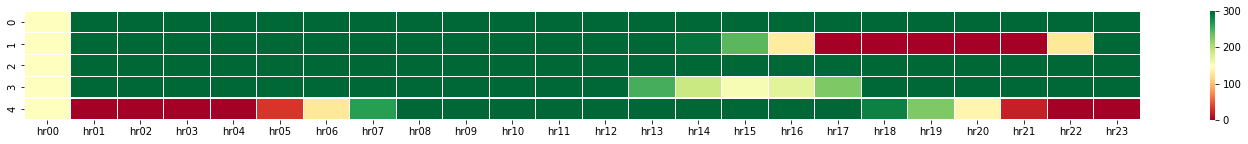

In [14]:
fig, ax = plt.subplots(figsize = (25, 2))
sns.heatmap(batt_soc[:5], cmap ='RdYlGn', linewidths=0.30, annot=False, vmin=0, vmax=300)

In total, there are 66 places where the state of charge is sufficient in this model and for this arbitrarily chosen day (the state of charge does not drop below 0.1 kWh).

In [15]:
zeros = batt_soc.copy()
zeros = (zeros < 0.1).astype(int).sum(axis=1)
(zeros == 0).astype(int).sum()

68

With this consideration, with the assumptions made above (which are obviously extremely simplified) and on this arbitrarily chosen day, the state of charge of the buffer storage does not drop to a critical (no longer usable level) at 68 out of 114. At least here, further consideration seems worthwhile. Let's do that.

## Data of a whole week

Since all the days of the week differ at least a little in reality, I will now look at the course over all the days of the week. 

### Relative occupancy of gas stations - weekly trend

First, get the data from the database. This time the peak hours are to be retrieved for all days. The limiting characteristics are to remain the same as before. Data are retrieved from locations that have terms related to motorway in the name or address and are of the type gas station.

In [16]:
GDB = GasStationDB()
query = """SELECT * FROM portfolio.guest_quantities 
                 WHERE hr00 IS NOT NULL AND station_id IN 
                       (SELECT station_id FROM portfolio.stations 
                          WHERE LOWER(name) LIKE '%autobahn%' 
                          OR LOWER(name) LIKE '%bab%'
                          OR LOWER(address) LIKE '%autobahn%'
                          OR LOWER(address) LIKE '%bab%'
                 AND station_id IN 
                       (SELECT ts_stations_id FROM portfolio.type_place 
                          WHERE ts_types_id = 1))
                 ORDER BY station_id;
                 """
GDB.cur.execute(query)
table = GDB.cur.fetchall()
week_autobahn = pd.DataFrame(table)
GDB.conn.close()
week_autobahn[::300]

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1265,185,7,1,1,1,1,1,1,1,...,81,68,53,39,29,21,15,9,4,1
300,3888,561,6,63,63,64,64,65,66,67,...,69,69,68,67,66,65,64,64,63,63
600,15631,2256,5,1,1,1,1,1,1,1,...,18,25,29,28,22,14,5,1,1,1


Since I would like to use the following tasks more often in the coming analyses, I will briefly create two functions. One function outputs the data records of a previously defined location. The second function combines the data in the rows at peak times into a single row.

In [17]:
def select_station(df_week, station_id):
    return df_week[df_week[1] == station_id]

In [18]:
def combine_columns(df_week):
    df_T = df_week.T
    week = df_T.iloc[3:,0].append([df_T.iloc[3:,1], df_T.iloc[3:,2], df_T.iloc[3:,3], df_T.iloc[3:,4], df_T.iloc[3:,5], df_T.iloc[3:,6]])
    week = pd.DataFrame(week.reset_index()[0]).T
    return week

**Here I create the list with the IDs of the locations.**

In [19]:
stations = week_autobahn.copy()
stations =  stations.groupby([1]).count()
stations = [stat for stat in stations.reset_index()[1]]

**At this point, the data sets are merged location by location.**

The result should be a DataFrame containing all selected locations with the peak times of a week in each row. 

As some errors have occurred in individual data records during the collection of the data, these are treated as error exceptions and are not processed further.
 
The IDs of the data records with errors are collected in ``can_not_assign_station_id`` and their number is output.

In [20]:
df_week = week_autobahn.copy()
hours_of_a_week = pd.DataFrame()
can_not_assign_station_id = []
for station_id in stations:
    df_one_line = select_station(df_week, station_id)
    try:
        hours_of_a_week = hours_of_a_week.append(combine_columns(df_one_line), ignore_index=True)
    except:
        can_not_assign_station_id.append(station_id)
print('can not assign data of {} stations'.format(len(can_not_assign_station_id)))
hours_of_a_week[:5]

can not assign data of 2 stations


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,1,1,1,1,1,1,1,1,4,23,...,89,67,43,22,10,5,4,3,1,1
1,2,2,2,2,2,2,2,2,11,28,...,81,66,53,43,36,29,19,6,2,2
2,1,1,1,1,1,1,1,1,7,21,...,53,49,42,34,27,20,14,9,4,0
3,0,0,0,0,0,0,0,4,9,18,...,68,68,66,62,53,41,29,17,8,1
4,60,57,54,53,53,54,55,56,57,59,...,69,68,66,64,62,60,59,58,57,56


### Observations of peak hours over a period of one week

The heat map shows the relative occupancy rates of the locations for each hour of the week. Blue boxes indicate no to low occupancy. Red fields indicate high to 100% capacity occupancy.

Here it can be seen quite clearly that individual locations have relatively low occupancy rates on several days of the week. On the other hand, the location mentioned also has a weekday with a very pronounced capacity occupancy (see line 2).

<AxesSubplot:>

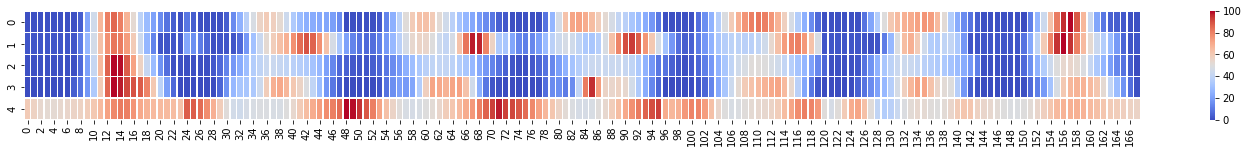

In [21]:
fig, ax = plt.subplots(figsize = (25, 2))
sns.heatmap(hours_of_a_week[:5], cmap ='coolwarm', linewidths = 0.30, annot = False)

### Same assessment with an example calculation

The rough calculation I made above for a single day I would now like to carry out for the duration of a whole week. The simplified basic assumptions are the same as above.

Again, please note: The results are only a rough estimate based on the collected data. Essential assumptions for a proper calculation are disregarded.

Here, too, a heat map is created. The green marked fields correspond to a very high or 100% State of Charge (SoC). The red fields correspond to a low or 0% State of Charge.

The first look at the heat map shows very quickly that the requirements (at least for the first five locations) could not be met. In all locations there are hours where the State of Charge is zero.

In [22]:
def get_batt_soc(hr_week, charge_max=800.0, grid_charge=504, batt_capa_max=300.0):
    batt_capa = 0.5 * batt_capa_max
    peak_time = hr_week.copy()

    batt_soc = pd.DataFrame(np.zeros((peak_time.shape[0], 1)))
    batt_next = pd.Series(dtype='float64')
    for i in peak_time.columns:
        if batt_next.empty:
            batt_soc[i] = 150
        else:
            batt_discharge = batt_next - (peak_time[i] * charge_max / 100) + grid_charge
            batt_soc[i] = batt_discharge.apply(lambda x: x if x <= batt_capa_max else batt_capa_max)
            batt_soc[i] = batt_soc[i].apply(lambda x: x if x >= 0.0 else 0.0)
        batt_next = batt_soc[i]
    return batt_soc

In [23]:
batt_soc = get_batt_soc(hours_of_a_week)[:5]
batt_soc[:5]

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,150,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,0.0,0.0,160.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
1,150,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,0.0,0.0,80.0,240.0,300.0,300.0,300.0,300.0,300.0,300.0
2,150,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
3,150,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,228.0,188.0,164.0,172.0,252.0,300.0,300.0,300.0,300.0,300.0
4,150,198.0,270.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,140.0,100.0,76.0,68.0,76.0,100.0,132.0,172.0,220.0,276.0


<AxesSubplot:>

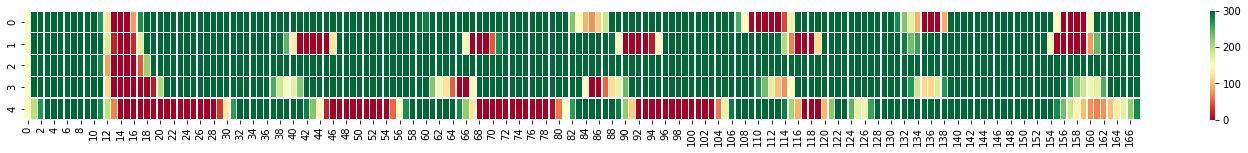

In [24]:
fig, ax = plt.subplots(figsize = (25, 2))
sns.heatmap(batt_soc[:5], cmap ='RdYlGn', linewidths=0.30, annot=False, vmin=0, vmax=300)

Thus, I look at all the sites. I check how many locations comply with the arbitrary conditions set above. The result is sobering, as the conditions cannot be met at any location. There is no location where the state of charge does not drop to zero at least once. But for comparison: the picture without storage would probably look similar.

In [25]:
zeros = batt_soc.copy()
zeros = (zeros == 0).astype(int).sum(axis=1)
(zeros == 0).astype(int).sum()

0

## Dependency of the ratio between battery capacity and residual grid power


### Ratio 3:1 - battery capacity to residual grid-power 

How about if I give the battery a larger capacity. Above you could see quite well that the battery had times when it was fully charged for several hours and then discharged within only one hour (the conditions set above also provoked this; the maximum capacity of the original battery could only deliver full power for one hour).

I triple the capacity of the battery storage system and see at how many locations the conditions can be met with it.

A look at the heat map still shows no continuous green fields for the first five locations. But something has already changed.

In [26]:
batt_soc_2 = get_batt_soc(hours_of_a_week, batt_capa_max=900.0)
batt_soc_2[:5]

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,150,646.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,...,0.0,0.0,160.0,488.0,900.0,900.0,900.0,900.0,900.0,900.0
1,150,638.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,...,0.0,0.0,80.0,240.0,456.0,728.0,900.0,900.0,900.0,900.0
2,150,646.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,...,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
3,150,654.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,...,828.0,788.0,764.0,772.0,852.0,900.0,900.0,900.0,900.0,900.0
4,150,198.0,270.0,350.0,430.0,502.0,566.0,622.0,670.0,702.0,...,740.0,700.0,676.0,668.0,676.0,700.0,732.0,772.0,820.0,876.0


<AxesSubplot:>

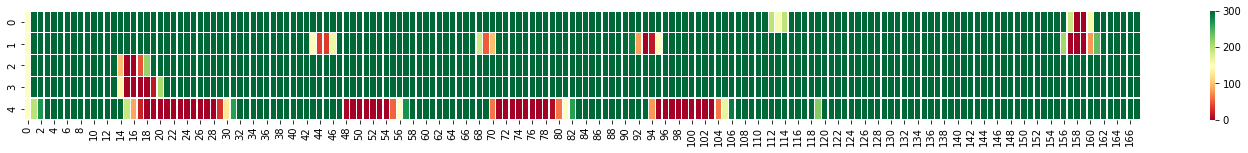

In [27]:
fig, ax = plt.subplots(figsize = (25, 2))
sns.heatmap(batt_soc_2[:5], cmap ='RdYlGn', linewidths=0.30, annot=False, vmin=0, vmax=300)

The query across all sites at least shows that the conditions for 10 sites have been met. I will continue to look.

In [28]:
zeros_2 = batt_soc_2.copy()
zeros_2 = (zeros_2 == 0).astype(int).sum(axis=1)
(zeros_2 == 0).astype(int).sum()

10

### Autobahn - dependency of the ratio

... between battery capacity and residual grid power

Earlier I increased the ratio of battery capacity vs. residual charging power from the grid from 1 to 3. This allowed me to increase the condition that the State of Charge (SoC) does not drop to zero at any hour during the week from 0 to 10. What does this look like if I simply increase this ratio further? At how many locations can I achieve the > 0 SoC condition at what ratio of battery capacity to residual charging power?

The diagram shows the ratio of battery capacity (batt_capa_max) to residual power (charge_max - grid_charge) in relation to the number of locations that could be served with that ratio.

It can be seen that the number of locations clearly increases from a ratio of 3. At the same time, however, it can be seen that locations with certain loads can probably no longer be served so easily by such storage systems (but this is in the nature of storage systems).

<AxesSubplot:title={'center':'AUTOBAHN / BAB \n relation of number covered to ratio battery capacity / residual power'}, xlabel='ratio'>

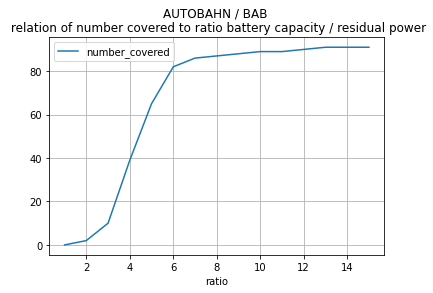

In [29]:
charge_max = 800
grid_charge = 504
ratio_batt_grid_residual = pd.DataFrame(columns=['ratio', 'number_covered'])
for i in range(1,16):
    batt_capa_max = i * (charge_max - grid_charge)
    batt_soc_n = get_batt_soc(hours_of_a_week, batt_capa_max=batt_capa_max)
    zeros_n = batt_soc_n.copy()
    zeros_n = (zeros_n == 0).astype(int).sum(axis=1)
    data_rbgr = {'ratio': i, 'number_covered': (zeros_n == 0).astype(int).sum()}
    ratio_batt_grid_residual = ratio_batt_grid_residual.append(data_rbgr, ignore_index=True)

ratio_batt_grid_residual.plot(x='ratio', y='number_covered', grid=True, title='AUTOBAHN / BAB \n relation of number covered to ratio battery capacity / residual power')

### Autohof -  dependency of the ratio

How much can be done at the other sites? First of all, the sites that are listed as Autohof (car parks) or that have this designation in their name or address.

There are 152 sites in the database that match the search terms.

In [30]:
GDB = GasStationDB()
query = """SELECT * FROM portfolio.guest_quantities 
                 WHERE hr00 IS NOT NULL AND station_id IN 
                       (SELECT station_id FROM portfolio.stations 
                          WHERE LOWER(name) LIKE '%autohof%' 
                          OR LOWER(address) LIKE '%autohof%')
                 ORDER BY station_id;
                 """
GDB.cur.execute(query)
table = GDB.cur.fetchall()
week_other = pd.DataFrame(table)
GDB.conn.close()
print(week_other.shape[0]/7)
week_other[::400]

151.0


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1292,189,7,53,53,53,53,52,50,48,...,68,67,66,65,65,65,63,60,57,54
400,5619,812,1,85,85,83,77,68,58,48,...,47,50,55,63,70,76,80,82,83,84
800,22459,3256,7,48,51,52,50,47,43,41,...,67,67,66,63,57,51,46,42,42,45


Here, the individual rows of the weekdays are combined into one row per station with the hours of an entire week.

In [31]:
stations_other = week_other.copy()
stations_other =  stations_other.groupby([1]).count()
stations_other = [stat for stat in stations_other.reset_index()[1]]

In [32]:
df_week_other = week_other.copy()
hours_of_a_week_other = pd.DataFrame()
can_not_assign_station_id = []
for station_id in stations_other:
    df_one_line = select_station(df_week_other, station_id)
    try:
        hours_of_a_week_other = hours_of_a_week_other.append(combine_columns(df_one_line), ignore_index=True)
    except:
        can_not_assign_station_id.append(station_id)
print('can not assign data of {} stations'.format(len(can_not_assign_station_id)))
hours_of_a_week_other[:5]

can not assign data of 4 stations


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,53,53,53,53,52,50,48,47,48,51,...,53,54,55,55,55,55,55,54,53,52
1,55,54,53,51,49,46,45,46,51,59,...,66,67,67,66,64,62,60,57,54,51
2,66,64,66,68,69,70,70,71,74,78,...,66,67,69,72,76,78,79,78,77,76
3,39,37,35,33,32,32,33,36,41,47,...,49,49,47,46,44,41,39,37,35,34
4,2,2,2,2,2,2,2,2,2,16,...,9,2,2,2,2,2,2,2,2,2


**The diagram here also shows a similar curve as for the motorway gas stations**

<AxesSubplot:title={'center':'AUTOHOF \n relation of number covered to ratio battery capacity / residual power'}, xlabel='ratio'>

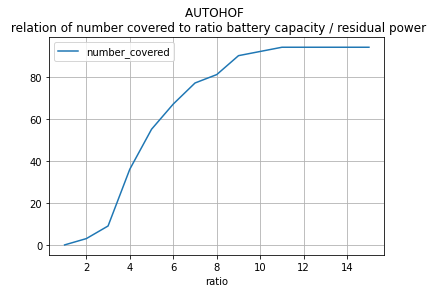

In [33]:
charge_max = 800
grid_charge = 504
ratio_batt_grid_residual_other = pd.DataFrame(columns=['ratio', 'number_covered'])
for i in range(1,16):
    batt_capa_max = i * (charge_max - grid_charge)
    batt_soc_n = get_batt_soc(hours_of_a_week_other, batt_capa_max=batt_capa_max)
    zeros_n = batt_soc_n.copy()
    zeros_n = (zeros_n == 0).astype(int).sum(axis=1)
    data_rbgr = {'ratio': i, 'number_covered': (zeros_n == 0).astype(int).sum()}
    ratio_batt_grid_residual_other = ratio_batt_grid_residual_other.append(data_rbgr, ignore_index=True)

ratio_batt_grid_residual_other.plot(x='ratio', y='number_covered', grid=True, title='AUTOHOF \n relation of number covered to ratio battery capacity / residual power')

### Service areas - dependency of the ratio

There are 269 service areas in the database. Now I'm going to take a look at them.

In [34]:
GDB = GasStationDB()
query = """SELECT * FROM portfolio.guest_quantities 
                 WHERE hr00 IS NOT NULL AND station_id IN 
                       (SELECT station_id FROM portfolio.stations 
                          WHERE LOWER(name) LIKE '%raststätte%' 
                          OR LOWER(address) LIKE '%raststätte%')
                 ORDER BY station_id;
                 """
GDB.cur.execute(query)
table = GDB.cur.fetchall()
week_rest_area = pd.DataFrame(table)
GDB.conn.close()
week_rest_area[::400]

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1453,212,7,2,2,2,2,2,2,2,...,100,98,90,77,60,42,26,12,3,2
400,21102,3053,1,0,0,0,0,0,0,1,...,44,40,38,38,38,35,30,23,0,0
800,22104,3197,2,5,5,7,7,1,2,2,...,30,33,44,60,74,78,69,50,29,12
1200,22994,3333,3,81,81,79,74,67,58,51,...,62,66,72,80,87,90,89,85,82,81
1600,24168,3501,4,63,55,48,44,41,39,38,...,54,58,63,71,79,85,88,86,81,72


In [35]:
rest_area = week_rest_area.copy()
rest_area =  rest_area.groupby([1]).count()
stations_rest_area = [stat for stat in rest_area.reset_index()[1]]

In [36]:
df_week_rest_area = week_rest_area.copy()
hours_of_a_week_rest_area = pd.DataFrame()
can_not_assign_station_id = []
for station_id in stations_rest_area:
    df_one_line = select_station(df_week_rest_area, station_id)
    try:
        hours_of_a_week_rest_area = hours_of_a_week_rest_area.append(combine_columns(df_one_line), ignore_index=True)
    except:
        can_not_assign_station_id.append(station_id)
print('can not assign data of {} stations'.format(len(can_not_assign_station_id)))
hours_of_a_week_rest_area[:5]

can not assign data of 1 stations


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,2,2,2,2,2,2,2,2,3,14,...,64,57,51,47,42,36,26,15,5,2
1,67,65,65,66,67,69,71,72,73,75,...,72,71,70,68,67,66,67,69,71,72
2,67,70,74,80,87,93,100,100,100,100,...,48,48,54,61,67,67,64,61,61,67
3,1,1,1,1,1,1,1,1,2,19,...,64,54,43,31,19,9,0,1,1,1
4,2,2,2,2,2,2,3,11,20,35,...,76,71,63,52,40,30,21,15,10,6


**For service areas, the same curve can be observed as before. However, the number of possible locations for a corresponding ratio is now slightly higher.**

<AxesSubplot:title={'center':'REST AREAS \n relation of number covered to ratio battery capacity / residual power'}, xlabel='ratio'>

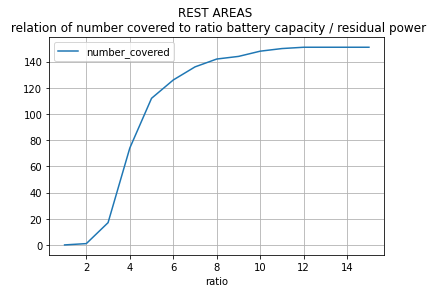

In [37]:
charge_max = 800
grid_charge = 504
ratio_batt_grid_residual_rest_area = pd.DataFrame(columns=['ratio', 'number_covered'])
for i in range(1,16):
    batt_capa_max = i * (charge_max - grid_charge)
    batt_soc_n = get_batt_soc(hours_of_a_week_rest_area, batt_capa_max=batt_capa_max)
    zeros_n = batt_soc_n.copy()
    zeros_n = (zeros_n == 0).astype(int).sum(axis=1)
    data_rbgr = {'ratio': i, 'number_covered': (zeros_n == 0).astype(int).sum()}
    ratio_batt_grid_residual_rest_area = ratio_batt_grid_residual_rest_area.append(data_rbgr, ignore_index=True)

ratio_batt_grid_residual_rest_area.plot(x='ratio', y='number_covered', grid=True, title='REST AREAS \n relation of number covered to ratio battery capacity / residual power')

### All locations - dependency of the ratio

Finally, I would like to look at how many of all the sites in the database would meet the condition. At how many locations would the peak hour profiles allow storage systems to be helpful there to support the charging infrastructure or relieve the load on the electricity grid.

There are profiles of 7175 sites in the database. As can be seen, 548 of these locations are not suitable for evaluation because their peak hour profiles are incomplete or incorrect. I can now process around 6,600 profiles.

In [38]:
GDB = GasStationDB()
query = """SELECT * FROM portfolio.guest_quantities  
                 WHERE hr00 IS NOT NULL 
                 ORDER BY station_id;
                 """
GDB.cur.execute(query)
table = GDB.cur.fetchall()
week_all = pd.DataFrame(table)
GDB.conn.close()
print(week_all.shape[0]/7)
week_all[:2]

7174.857142857143


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1,1,7,0,0,0,0,0,0,1,...,72,70,63,52,39,26,14,5,0,0
1,2,1,1,0,0,0,0,0,19,33,...,99,88,72,54,38,27,18,11,0,0


In [39]:
all_ = week_all.copy()
all_ =  all_.groupby([1]).count()
stations_all = [stat for stat in all_.reset_index()[1]]

In [40]:
df_week_all = week_all.copy()
hours_of_a_week_all = pd.DataFrame()
can_not_assign_station_id = []
for station_id in stations_all:
    df_one_line = select_station(df_week_all, station_id)
    try:
        hours_of_a_week_all = hours_of_a_week_all.append(combine_columns(df_one_line), ignore_index=True)
    except:
        can_not_assign_station_id.append(station_id)
print('can not assign data of {} stations'.format(len(can_not_assign_station_id)))
hours_of_a_week_all[:5]

can not assign data of 548 stations


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,0,0,0,0,0,0,1,8,18,30,...,58,56,55,53,48,38,24,11,0,0
1,0,0,0,0,0,0,0,1,8,23,...,62,54,50,50,48,35,18,4,0,0
2,0,1,1,1,2,11,16,16,15,21,...,36,33,29,24,19,14,9,4,0,1
3,4,0,1,1,1,1,1,1,5,26,...,66,68,69,60,42,25,17,15,15,13
4,1,1,1,1,1,1,1,1,0,30,...,42,49,57,61,58,50,36,24,14,6


**From a fundamental point of view, little changes in the course of the curve. However, the number of locations that could comply with the conditions according to the ratio is significantly higher than for the other locations.**

<AxesSubplot:title={'center':'ALL LOCATIONS \n relation of number covered to ratio battery capacity / residual power'}, xlabel='ratio'>

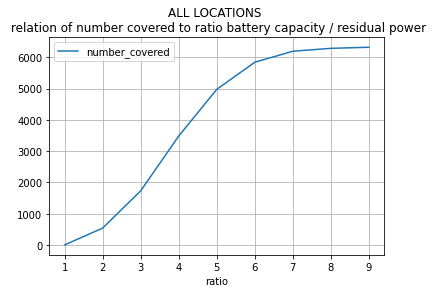

In [41]:
charge_max = 800
grid_charge = 504
ratio_batt_grid_residual_all = pd.DataFrame(columns=['ratio', 'number_covered'])
for i in range(1,10):
    batt_capa_max = i * (charge_max - grid_charge)
    batt_soc_n = get_batt_soc(hours_of_a_week_all, batt_capa_max=batt_capa_max)
    zeros_a = batt_soc_n.copy()
    zeros_a = (zeros_a == 0).astype(int).sum(axis=1)
    data_all = {'ratio': i, 'number_covered': (zeros_a == 0).astype(int).sum()}
    ratio_batt_grid_residual_all = ratio_batt_grid_residual_all.append(data_all, ignore_index=True)

ratio_batt_grid_residual_all.plot(x='ratio', y='number_covered', grid=True, title='ALL LOCATIONS \n relation of number covered to ratio battery capacity / residual power')

## Summary

It is not really possible to make reliable statements on the suitability of storage systems with simple statistical values on the number of users (average occupancy rates, frequencies, etc.). It is particularly difficult to use very short time series (weekdays differ). A time series approach over a longer period seems to be somewhat more reliable. However, for specific projects, the relative visitor numbers should be backed up with current and absolute figures.

Last but not least, the suitability of a storage system is linked to many other factors that have not been considered here. Furthermore, it must be taken into account that not everyone is currently driving an electric car; this means that the actual occupancy profiles will differ greatly from those used here. In addition, the type of operation of the charging stations plays a significant role; a location with a café is to be assessed differently than a location without, as these are frequented differently. 

Based on the rough estimates, I assume that charging locations with battery storage will not be unusual in Germany. 

I would find the following further investigations helpful in narrowing down the search:
- Narrowing down the search by geographical distance (e.g. rest areas near motorways).
- the influence of geographical proximity to conurbations on peak times
- a more precise distinction between service areas and petrol stations
- Observation of the deviations of peak times from the average values over a longer period of time. 

As I have written several times, the assumptions I have made are very woodcut-like and should therefore be used with caution. 

And as actually the most important point not to forget: Absolute figures and appropriate design simulations should be used for the design of storage systems instead of relative figures and such a rough balancing calculation.